In [3]:
# Important stuff
import os
import sys
from pathlib import Path
import json
import numpy as np

# Enables the notebook to access root:
root_path = Path.cwd().parent
sys.path.append(str(root_path))

# Repo stuff
from geometry_metrics import compute_spectral_entropy, cosine_similarity_matrix, sliding_window, calculate_angles
from se_correlation import encode_labelset, compute_entropies

# Plots and pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import umap
from sklearn.decomposition import PCA

# CLIP/Torch
import clip
import torch
from torchvision.datasets import CIFAR100

# Statistics stuff
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import gaussian_kde

import warnings
# Suppress UMAP warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/home/friis/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading CLIP ViT-L/14@336px...")
#Force the model to use float32:
model = clip.load("ViT-L/14@336px", jit=False, device=torch.device("cpu"))[0].to(device)

Loading CLIP ViT-L/14@336px...


In [6]:
pca = PCA(n_components=2)
Dataset = "Dataset" 

embedding_path = f"../Embeddings/{Dataset}.json"
label_path = f"../Data/{Dataset}/labels.json"

with open(embedding_path, "r", encoding="utf-8") as f:
    embedding_dict = json.load(f)["rot"]

for obj in embedding_dict:
    embedding_dict[obj] = np.array(
        [embedding_dict[obj][str(key)] for key in sorted(map(int, embedding_dict[obj].keys()))],
        dtype=np.float32
    )

In [7]:
Dataset = "coil100" 
label_path = f"../Data/{Dataset}/labels.json"
with open(label_path, "r", encoding="utf-8") as f:
        label_idx_dict = json.load(f)
 
label_names = list(label_idx_dict.keys())
text_features = encode_labelset(label_names, model, device)

Encoding Labelset: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


In [11]:
def UMAP_projection(embeddings, random_seed = 42):
    reducer = umap.UMAP(random_state=random_seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

PCA_text = pca.fit_transform(text_features.cpu().numpy())
UMAP_text = UMAP_projection(text_features.cpu().numpy(), random_seed=42)

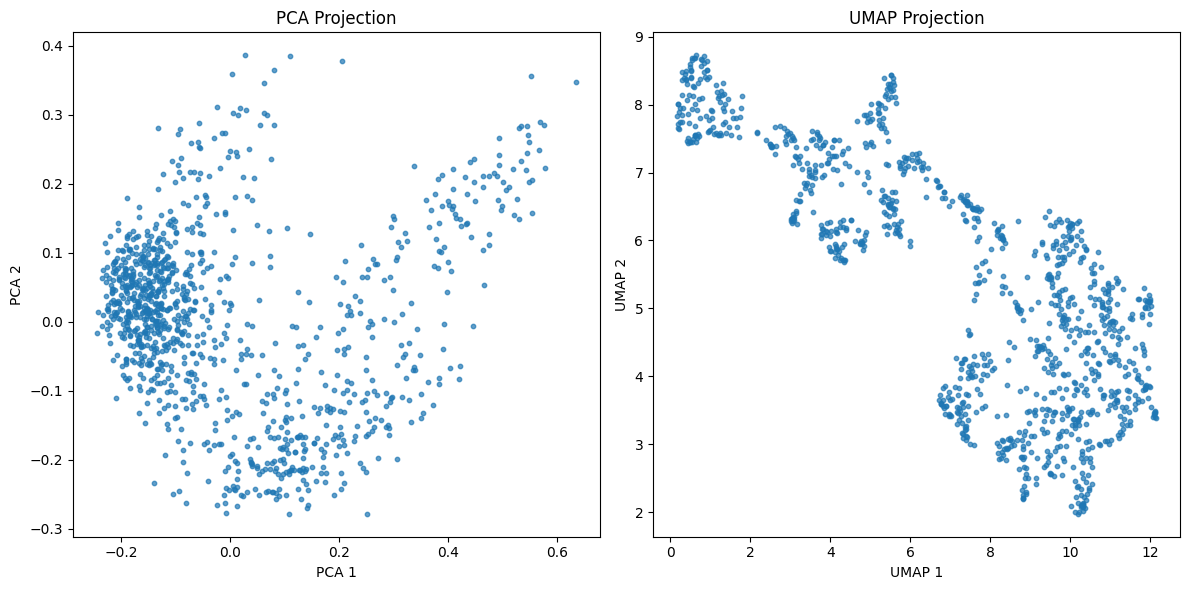

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PCA plot
axes[0].scatter(PCA_text[:, 0], PCA_text[:, 1], s=10, alpha=0.7)
axes[0].set_title("PCA Projection")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# UMAP plot
axes[1].scatter(UMAP_text[:, 0], UMAP_text[:, 1], s=10, alpha=0.7)
axes[1].set_title("UMAP Projection")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

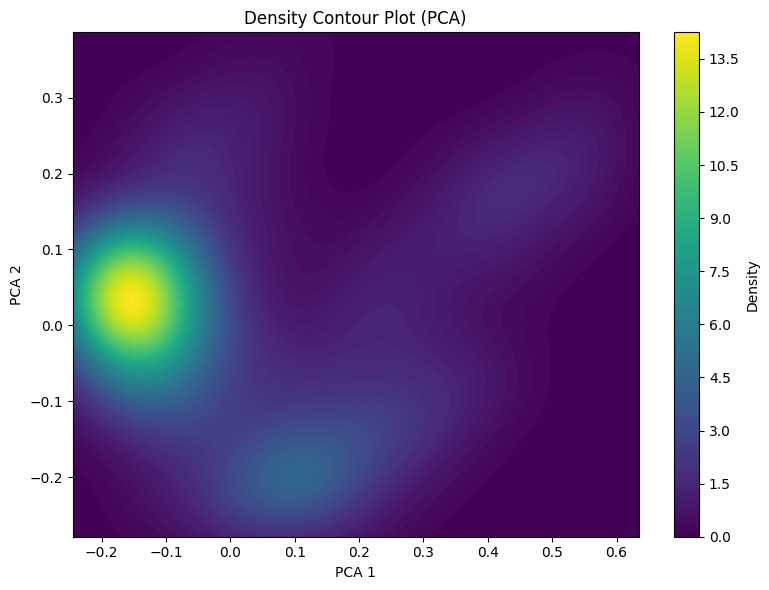

In [13]:

key = "PCA"
dict_ = {"UMAP": UMAP_text, "PCA": PCA_text}
dict_[key]

data = dict_[key].T  # shape -> (2, N) for gaussian_kde
kde = gaussian_kde(data)
x_min, x_max = data[0].min(), data[0].max()
y_min, y_max = data[1].min(), data[1].max()

# Grid for KDE
x_grid, y_grid = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(positions).reshape(x_grid.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, density, levels = 100, cmap="viridis")
#plt.scatter(data[0], data[1], s=5, color="white", alpha=0.6) #point overlay
plt.title(f"Density Contour Plot ({key})")
plt.xlabel(f"{key} 1")
plt.ylabel(f"{key} 2")
plt.colorbar(label="Density")
plt.tight_layout()
plt.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


/tmp/ipykernel_1445/4183426647.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


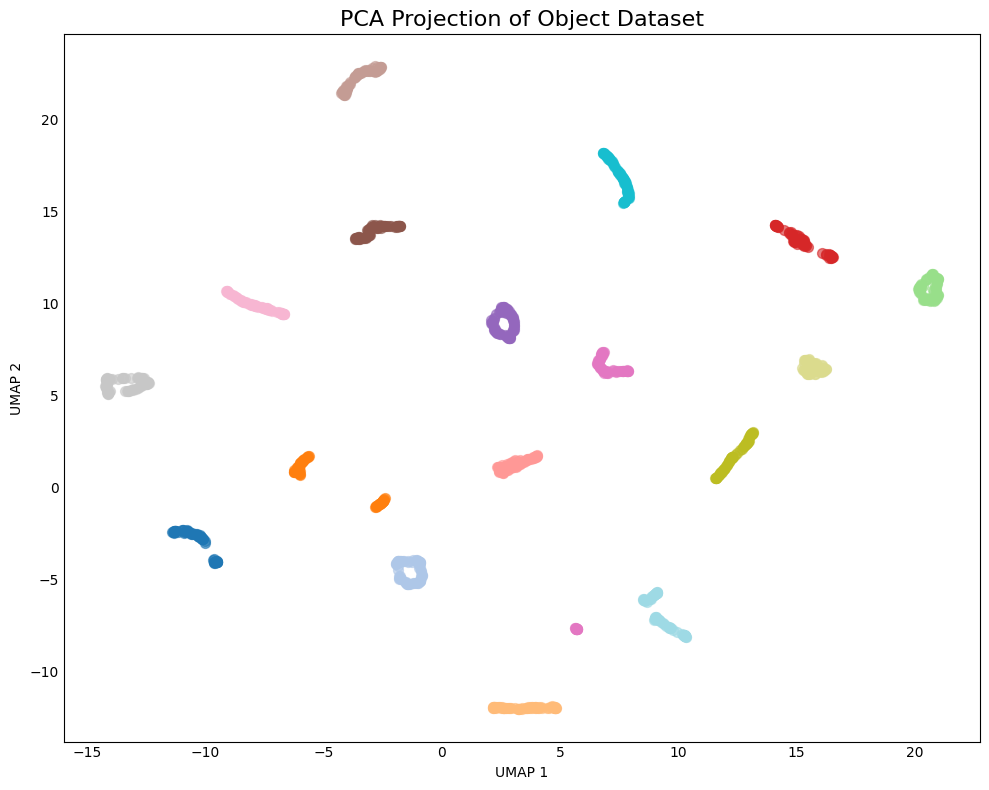

In [15]:

all_embeddings_raw = []
labels = []

print(plt.style.available)

for obj_name, embedding_matrix in embedding_dict.items():
    all_embeddings_raw.append(embedding_matrix)
    labels.extend([obj_name] * embedding_matrix.shape[0])


all_embeddings_raw = np.vstack(all_embeddings_raw)
labels = np.array(labels)

# --- Choose projection method ---
method = "umap"  # or "pca"
if method == "umap":
    model_ = umap.UMAP(n_components=2, random_state=42)
elif method == "pca":
    model_ = PCA(n_components=2)
else:
    raise ValueError("Unknown projection method")

projected = model_.fit_transform(all_embeddings_raw)

# --- If PCA: get explained variance
if method == "pca":
    print("Explained variance ratio:", model_.explained_variance_ratio_)
    print("Total explained variance:", sum(model_.explained_variance_ratio_))

unique_labels = sorted(set(labels))
cmap = cm.get_cmap('tab20', len(unique_labels))
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}


plt.style.use('default')
plt.figure(figsize=(10, 8))
for label in unique_labels:
    idxs = labels == label
    plt.scatter(
        projected[idxs, 0],
        projected[idxs, 1],
        color=label_to_color[label],
        label=label,
        s=50,
        alpha=0.6
    )

plt.title("PCA Projection of Object Dataset", fontsize=16)
plt.xlabel(f"{method.upper()} 1")
plt.ylabel(f"{method.upper()} 2")
plt.tick_params(axis='both', which='both', length=0)

if Dataset != "coil100":
    plt.legend(
        #title="Objects",
        loc="lower left",
        bbox_to_anchor=(0.02, 0.02),
        fontsize=10,
        frameon=True,
        framealpha=0.85,     # transparency
        facecolor='white',   # background
        edgecolor='gray',
        markerscale=1
    )

plt.tight_layout()
plt.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


C:\Users\Friis\AppData\Local\Temp\ipykernel_12112\4221932065.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


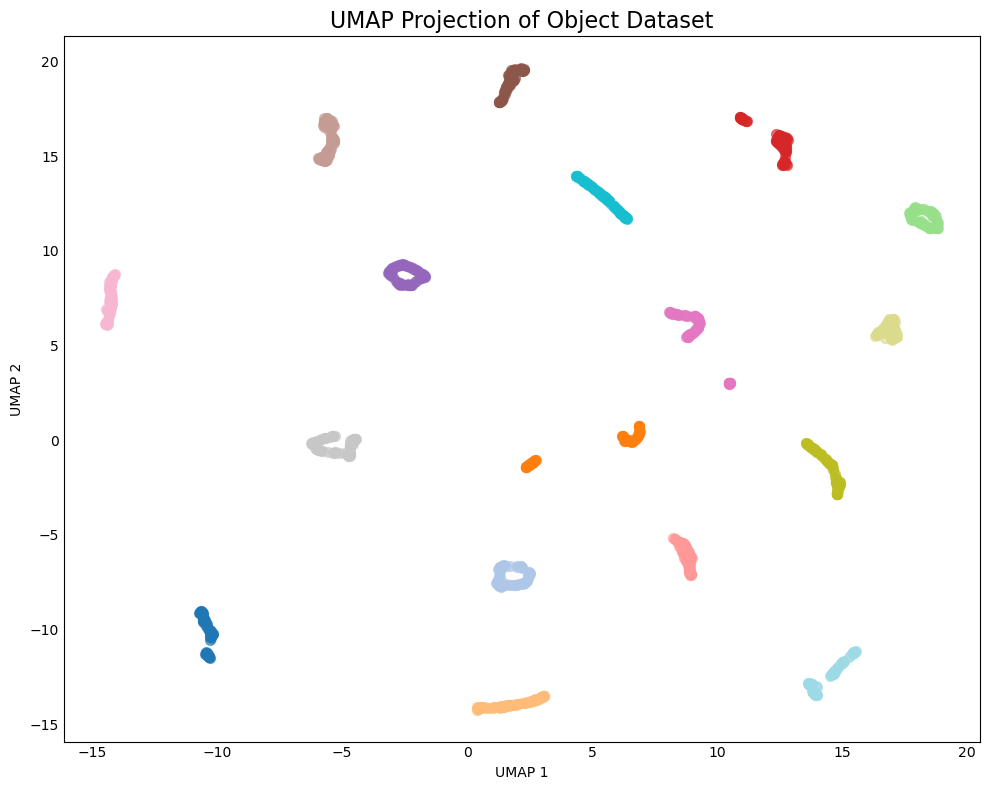

In [10]:

all_embeddings_raw = []
labels = []

print(plt.style.available)

for obj_name, embedding_matrix in embedding_dict.items():
    all_embeddings_raw.append(embedding_matrix)
    labels.extend([obj_name] * embedding_matrix.shape[0])
all_embeddings_raw = np.vstack(all_embeddings_raw)
labels = np.array(labels)

# --- Choose projection method ---
method = "umap"  
if method == "umap":
    _model = umap.UMAP(n_components=2, random_state=42)
elif method == "pca":
    _model = PCA(n_components=2)
else:
    raise ValueError("Unknown projection method")

projected = _model.fit_transform(all_embeddings_raw)

unique_labels = sorted(set(labels))
cmap = cm.get_cmap('tab20', len(unique_labels))
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

plt.style.use('default')
plt.figure(figsize=(10, 8))
for label in unique_labels:
    idxs = labels == label
    plt.scatter(
        projected[idxs, 0],
        projected[idxs, 1],
        color=label_to_color[label],
        label=label,
        s=50,
        alpha=0.6
    )

plt.title("UMAP Projection of Object Dataset", fontsize=16)
plt.xlabel(f"{method.upper()} 1")
plt.ylabel(f"{method.upper()} 2")
plt.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

In [16]:
entropy_list = {}

for obj_name, embedding_matrix in embedding_dict.items():
    spectral_entropy = compute_spectral_entropy(cosine_similarity_matrix(embedding_matrix))
    entropy_list[obj_name] = spectral_entropy

for k, v in sorted(entropy_list.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.4f}")

# print SE for latex table

faxe_kondi: 0.7088
wrist_watch: 0.6837
combination_lock: 0.5609
lego_man: 0.5605
toy_car: 0.5460
charger: 0.5109
light_bulb: 0.4321
battery: 0.3604
sun_glasses: 0.3381
duct_tape: 0.2852
controller: 0.2571
rubiks_cube: 0.2562
cup_with_handle: 0.1975
rubber_duck: 0.1923
lego_brick: 0.1485
thermo_cup: 0.0849
cup_no_handle: 0.0405


In [12]:
import matplotlib.colors as mcolors

latex_colors = {
    label: mcolors.to_hex(cmap(i))
    for i, label in enumerate(unique_labels)
}
# return colors for latex table
latex_colors

{np.str_('battery'): '#1f77b4',
 np.str_('charger'): '#aec7e8',
 np.str_('combination_lock'): '#ff7f0e',
 np.str_('controller'): '#ffbb78',
 np.str_('cup_no_handle'): '#98df8a',
 np.str_('cup_with_handle'): '#d62728',
 np.str_('duct_tape'): '#ff9896',
 np.str_('faxe_kondi'): '#9467bd',
 np.str_('lego_brick'): '#8c564b',
 np.str_('lego_man'): '#c49c94',
 np.str_('light_bulb'): '#e377c2',
 np.str_('rubber_duck'): '#f7b6d2',
 np.str_('rubiks_cube'): '#c7c7c7',
 np.str_('sun_glasses'): '#bcbd22',
 np.str_('thermo_cup'): '#dbdb8d',
 np.str_('toy_car'): '#17becf',
 np.str_('wrist_watch'): '#9edae5'}

Encoding Labelset: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

vehicle: 0.2207
car: 0.2220
toy car: 0.2576
grey toy car: 0.2690
small grey toy car: 0.2911
small skoda superb toy car: 0.3408
small skoda superb toy car on a white table with a dim background: 0.3702


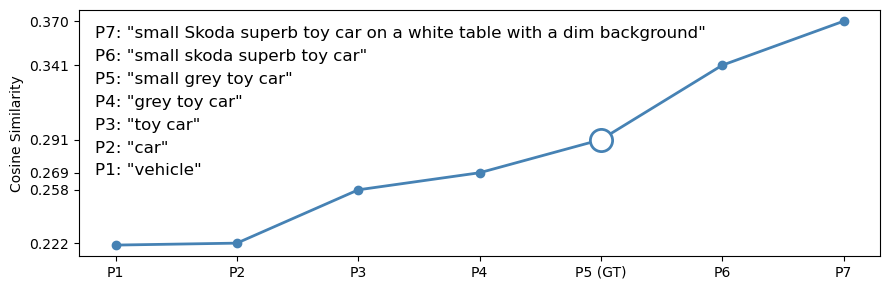

In [13]:
import torch.nn.functional as F


vect = embedding_dict["toy_car"][0]
vect_torch = torch.tensor(vect, dtype=text_features.dtype, device=text_features.device)

label_names = ["vehicle", "car", "toy car", "grey toy car", "small grey toy car", "small skoda superb toy car","small skoda superb toy car on a white table with a dim background"]

text_features = encode_labelset(label_names, model, device)

vect_torch = F.normalize(vect_torch, dim=0)           # shape (768,)
text_features = F.normalize(text_features, dim=1)     # shape (N, 768)

scores = text_features @ vect_torch
for label, score in zip(label_names, scores):
    print(f"{label}: {score.item():.4f}")

prompts_table = [
    'P7: "small Skoda superb toy car on a white table with a dim background" ',
    'P6: "small skoda superb toy car" ',
    'P5: "small grey toy car" ',
    'P4: "grey toy car" ',
    'P3: "toy car" ',
    'P2: "car" ',
    'P1: "vehicle" '
]

#should be the other way around ohh well
similarities = [0.3702, 0.3408, 0.2911, 0.2690, 0.2576, 0.2220, 0.2207]
xticks = ["P1", "P2", "P3", "P4", "P5 (GT)", "P6", "P7"]

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(xticks, similarities[::-1], marker='o', linewidth=2, color='steelblue')
ax.set_ylabel("Cosine Similarity")

highlight_index = 4  
ax.plot(
    xticks[highlight_index],
    similarities[::-1][highlight_index],
    marker='o',
    markersize=16,
    markerfacecolor='white',
    markeredgecolor='steelblue',
    markeredgewidth=2,
    label='Highlighted P5'
)

yticks = similarities[::-1][1:]
ytick_labels = [f"{s:.3f}" for s in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

table = plt.table(
    cellText=[[p] for p in prompts_table],
    rowLabels=None,
    loc='upper left',
    bbox=[0, 0.3, 0.2, 0.65],
    cellLoc='left',
    colLoc='left'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1)

# Remove table lines
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

plt.tight_layout()
plt.show()


In [14]:

df = pd.read_csv('../entropy_analysis.csv')
acc = df["accuracy"].to_numpy()
SE = df["spectral_entropy"].to_numpy()
SD = df["semantic_density"].to_numpy()

# Taking out each dataset
x1 = SE[0:100]
x2 = SE[100:]
y1 = acc[0:100]
y2 = acc[100:]
SD1 = SD[0:100]
SD2 = SD[100:]

all_SD = np.concatenate([SD1, SD2])
all_acc = np.concatenate([y1, y2])

df

,object,accuracy,spectral_entropy,semantic_density
0,obj17,0.996958,0.402799,0.027569
1,obj42,0.564389,0.455510,1.070003
2,obj9,0.285602,0.683135,1.961255
3,obj26,0.286283,0.640576,1.353407
4,obj88,0.593054,0.454672,1.415951
...,...,...,...,...
112,sun_glasses,0.754342,0.338127,0.734271
113,faxe_kondi,0.992440,0.708847,0.042076
114,lego_brick,0.962748,0.148461,0.299280
115,controller,0.906914,0.257122,0.358155


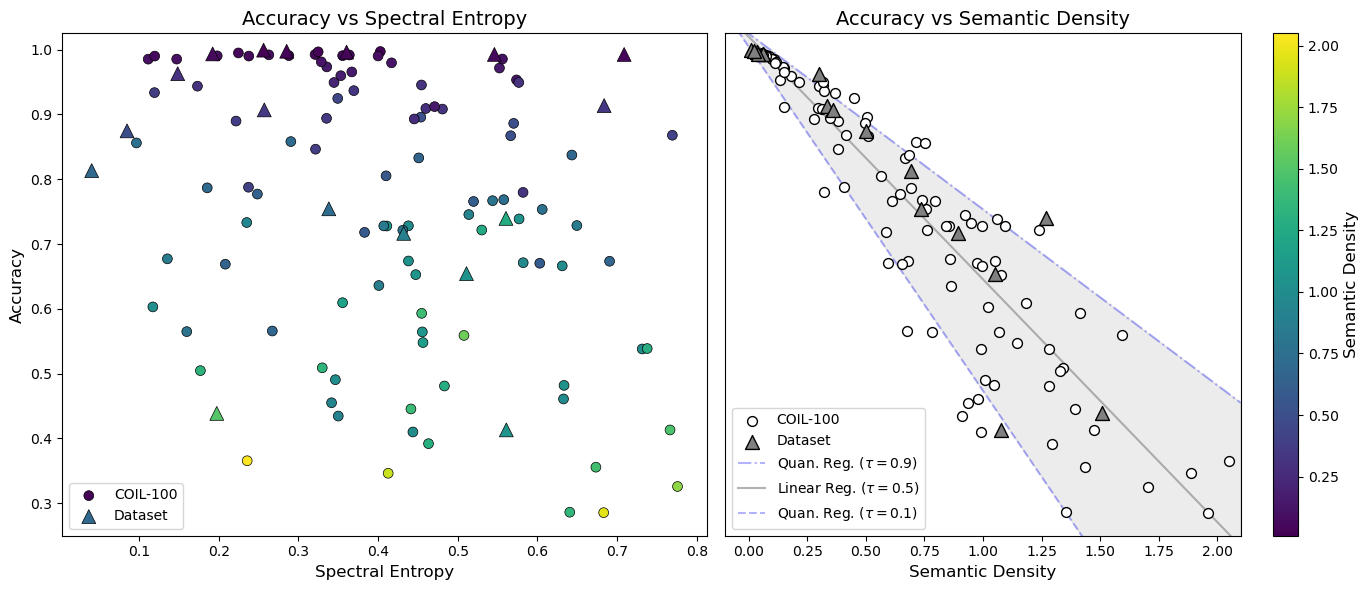

In [ ]:

# Prepare data
X = sm.add_constant(all_SD)
xlim_low, xlim_high = -0.1, 2.1  # <<< Adjust x-axis range here easily
x_full = np.linspace(xlim_low, xlim_high, 500)
X_full = sm.add_constant(x_full)

# Fit quantile models across full x-range
model_10 = QuantReg(all_acc, X).fit(q=0.1)
model_50 = QuantReg(all_acc, X).fit(q=0.5)
model_90 = QuantReg(all_acc, X).fit(q=0.9)

y_10_full = model_10.predict(X_full)
y_50_full = model_50.predict(X_full)
y_90_full = model_90.predict(X_full)

# Prepare figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot
sc1 = ax1.scatter(x1, y1, c=SD1, cmap="viridis", alpha=1, marker="o", s=50, edgecolors="black", label="COIL-100", linewidths=0.5)
sc2 = ax1.scatter(x2, y2, c=SD2, cmap="viridis", alpha=1, marker="^", s=100, edgecolors="black", label="Dataset", linewidths=0.5)
ax1.set_xlabel("Spectral Entropy", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Accuracy vs Spectral Entropy", fontsize=14)
ax1.set_ylim(0.25, 1.025)
ax1.legend(loc="lower left")

# Makes the color bar the correct range
vmin = min(SD1.min(), SD2.min())
vmax = max(SD1.max(), SD2.max())
sc1.set_clim(vmin, vmax)
sc2.set_clim(vmin, vmax)

# Right plot
ax2.scatter(SD1, y1, color="white", edgecolors="black", label="COIL-100", marker="o", s=50, zorder=3)
ax2.scatter(SD2, y2, color="gray", edgecolors="black", label="Dataset", marker="^", s=100, zorder=3)
ax2.set_xlabel("Semantic Density", fontsize=12)
ax2.set_title("Accuracy vs Semantic Density", fontsize=14)
ax2.set_yticks([])
ax2.set_ylim(0.25, 1.025)
ax2.set_xlim(xlim_low, xlim_high)
ax2.legend(loc="lower left")

# Quantile regression bands
ax2.fill_between(x_full, y_10_full, y_90_full, color='gray', alpha=0.15, zorder=0)

ax2.plot(x_full, y_90_full, linestyle='dashdot', color='blue', alpha=0.3,  zorder=2, label=r'Quan. Reg. ($\tau = 0.9$)')
ax2.plot(x_full, y_50_full, linestyle='-', color='gray', alpha=0.6, zorder=1, label=r'Linear Reg. ($\tau = 0.5$)')
ax2.plot(x_full, y_10_full, linestyle='dashed', color='blue', alpha=0.3,  zorder=2, label=r'Quan. Reg. ($\tau = 0.1$)')

# Colorbar
cbar = fig.colorbar(sc2, ax=ax2)
cbar.set_label("Semantic Density", fontsize=12)

ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [18]:
df1 = pd.read_csv("../cifartest.csv")
print(df1.columns)
acc = df1["accuracy"].to_numpy()
SD = df1["semantic_density"].to_numpy()
class_names = df1["class"].to_numpy()

Index(['class', 'semantic_density', 'accuracy'], dtype='object')


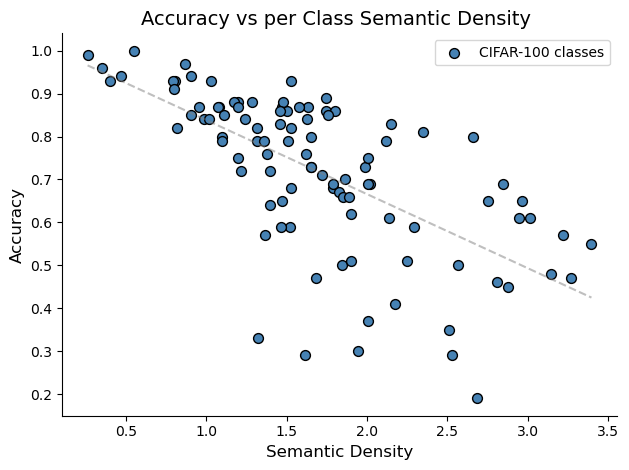

In [19]:
# Not really used anymore - no quantile bars
plt.figure()
plt.scatter(x = SD, y =  acc, color="steelblue", edgecolors="black", label="CIFAR-100 classes", marker="o", s=50)
plt.xlabel("Semantic Density", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)  
plt.title("Accuracy vs per Class Semantic Density ", fontsize=14)
plt.legend()
plt.tight_layout() 

ax = plt.gca()  # Get current Axes
ax.spines[['right', 'top']].set_visible(False)

m, b = np.polyfit(SD, acc, 1)
sorted_idx = np.argsort(SD)
x_sorted = SD[sorted_idx]
y_sorted = m * x_sorted + b

plt.plot(x_sorted, y_sorted, color='gray', linestyle='--', alpha=0.5)
plt.show()


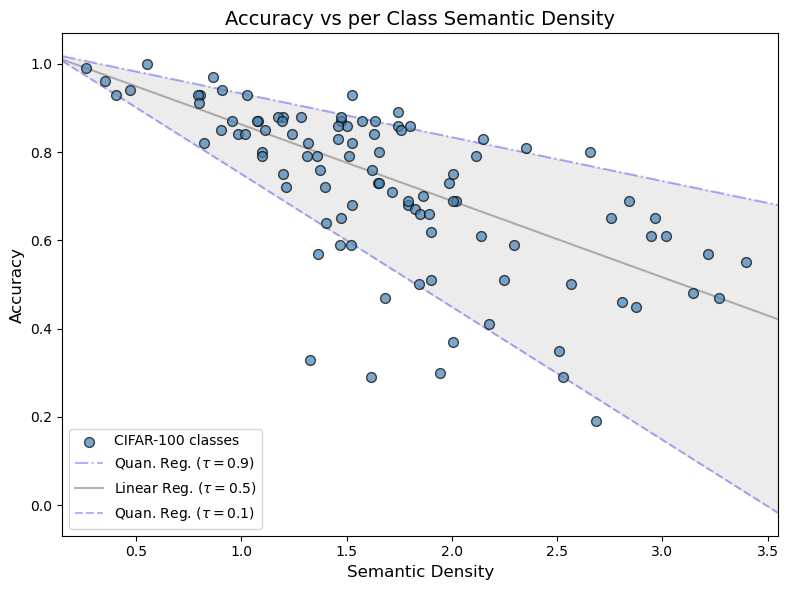

In [20]:

# Add constant
X = sm.add_constant(SD)
quantiles = [0.1, 0.5, 0.9]
quantile_preds = {}

# Fit models
for q in quantiles:
    model2 = QuantReg(acc, X)
    res = model2.fit(q=q)
    quantile_preds[q] = res.predict(X)

# Fixed x-range
xlim_low, xlim_high = 0.15, 3.55
x_full = np.linspace(xlim_low, xlim_high, 500)
X_full = sm.add_constant(x_full)

# Predict full-range quantile lines
model_10 = QuantReg(acc, X).fit(q=0.1)
model_50 = QuantReg(acc, X).fit(q=0.5)
model_90 = QuantReg(acc, X).fit(q=0.9)

y_10_full = model_10.predict(X_full)
y_50_full = model_50.predict(X_full)
y_90_full = model_90.predict(X_full)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(SD, acc, alpha=0.7, edgecolors='black', label='CIFAR-100 classes',
            color='steelblue', s=50, zorder=3)

plt.fill_between(x_full, y_10_full, y_90_full, color='gray', alpha=0.15, zorder=1)
plt.plot(x_full, y_90_full, linestyle='dashdot', color='blue', alpha=0.3, label=r'Quan. Reg. ($\tau = 0.9$)')
plt.plot(x_full, y_50_full, linestyle='-', color='gray', alpha=0.6, label=r'Linear Reg. ($\tau = 0.5$)', zorder=2)
plt.plot(x_full, y_10_full, linestyle='dashed', color='blue', alpha=0.3, label=r'Quan. Reg. ($\tau = 0.1$)')

plt.xlabel("Semantic Density", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy vs per Class Semantic Density", fontsize=14)
plt.legend(loc="lower left")
plt.xlim(xlim_low, xlim_high)  # force clean framing
plt.tight_layout()
plt.grid(False)
plt.show()


In [21]:
mask = (df["semantic_density"] > 1) & (df["semantic_density"] < 2.5) & \
       (df["accuracy"] > 0.1) & (df["accuracy"] < 0.4)

outliers = df[mask].sort_values(by="semantic_density")
outliers

,object,accuracy,spectral_entropy,semantic_density
49,obj27,0.392012,0.463263,1.293128
3,obj26,0.286283,0.640576,1.353407
48,obj84,0.355728,0.673373,1.434980
57,obj65,0.325930,0.775840,1.703731
19,obj50,0.346344,0.412645,1.888808
2,obj9,0.285602,0.683135,1.961255
97,obj40,0.365643,0.235653,2.049935


['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

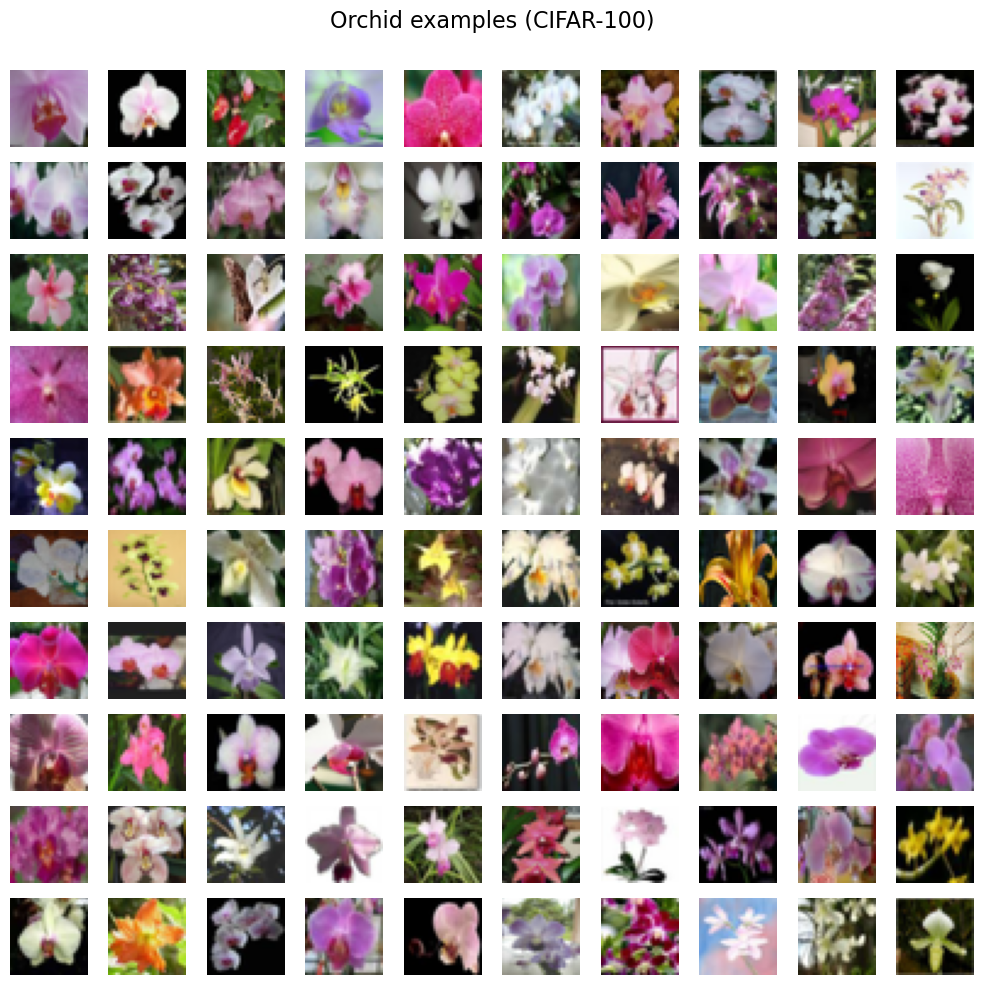

In [22]:


# Assume it's downloaded already in torchvision_data root
dataset = CIFAR100(root=os.path.expanduser("~/.torchvision_data"), train=False, download=False)
print(dataset.classes) # <- Available classes
target_class = "orchid"  

# Find all indices of that class
class_idx = dataset.classes.index(target_class)
indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]

# Take first 100 images of that class
images = [dataset[i][0] for i in indices[:100]]

# Create 10x10 grid 
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for ax, img in zip(axes.flatten(), images):
    ax.imshow(np.array(img))
    ax.axis('off')

plt.suptitle(f"{target_class.capitalize()} examples (CIFAR-100)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()